This Python notebook contains the code to reproduce the experiments in our [paper](https://arxiv.org/pdf/1911.04415.pdf):
> C. W. Combettes and S. Pokutta. Revisiting the Approximate Carathéodory Problem via the Frank-Wolfe Algorithm. *arXiv preprint arXiv:1911.04415*, 2019.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from itertools import compress
from scipy.linalg import hadamard

In [ ]:
labels = {'fw':'FW', 'nepfw':'NEP-FW', 'afw':'AFW', 'fcfw':'FCFW'}
colors = {'fw':'tab:blue', 'nepfw':'tab:purple', 'afw':'tab:orange', 'fcfw':'tab:green'}

def plotter(res, n, p, s, labels, colors, title, lower=False):
    
    fig = plt.figure()
    fig.set_figheight(3)
    fig.set_figwidth(3.5)

    for alg in res.keys():
        plt.plot(res[alg][2], res[alg][3], label=labels[alg], color=colors[alg])
    if lower == True:
        plt.plot(np.arange(1, n+1), [np.sqrt(1/s-1/n) for s in np.arange(1, n+1)], 
                 '--', color='tab:red', label='lower bound')
    plt.axvline(x=s, linestyle='--', label='card$(x^*)$', color='black')
    plt.yscale('log')
    
    plt.title(title)
    plt.ylabel('$||x_t-x^*||_p$')
    plt.xlabel('card$(x_t)$')
    plt.legend()

    plt.tick_params(which='minor', left=False)
    plt.grid(linestyle=':')
    
    plt.show()

# Algorithms

In [ ]:
def segment_search(f, grad_f, x, y, tol=1e-6, stepsize=True):
    
    '''
    Minimizes f over [x, y], i.e., f(x+gamma*(y-x)) as a function of scalar gamma in [0,1]
    '''
    
    # restrict segment of search to [x, y]
    d = (y-x).copy()
    left, right = x.copy(), y.copy()
    
    # if the minimum is at an endpoint
    if np.dot(d, grad_f(x))*np.dot(d, grad_f(y)) >= 0:
        if f(y) <= f(x):
            return y, 1
        else:
            return x, 0
    
    # apply golden-section method to segment
    gold = (1+np.sqrt(5))/2
    improv = np.inf
    while improv > tol:
        old_left, old_right = left, right
        new = left+(right-left)/(1+gold)
        probe = new+(right-new)/2
        if f(probe) <= f(new):
            left, right = new, right
        else:
            left, right = left, probe
        improv = np.linalg.norm(f(right)-f(old_right))+np.linalg.norm(f(left)-f(old_left))
    x_min = (left+right)/2
    
    # compute step size gamma
    gamma = 0
    if stepsize == True:
        for i in range(len(d)):
            if d[i] != 0:
                gamma = (x_min[i]-x[i])/d[i]
                break
                
    return x_min, gamma

def sigd(f, grad_f, x, S, alpha):
    
    '''
    Simplex Gradient Descent
    '''
    
    g = np.dot(S, grad_f(x))
    e, k = np.ones(len(S)), len(S)
    d = g-np.dot(g, e)*e/k
    
    if np.linalg.norm(d) == 0:
        return S[0], [S[0]], [1]
    
    eta = np.inf
    for i in range(len(alpha)):
        if d[i] > 0:
            eta = min(eta, alpha[i]/d[i])
    beta = np.array(alpha)-eta*d
    y = np.dot(beta, S)

    if f(x) >= f(y):
        idx = list(beta > 0)
        return y, list(compress(S, idx)), list(compress(beta, idx))
    
    else:
        x, gamma = segment_search(f, grad_f, x, y)
        return x, S, list((1-gamma)*np.array(alpha)+gamma*beta)

def find_index(v, S):
    
    for i in range(len(S)):
        if np.all(S[i] == v):
            return i
        
    return -1

## FW

In [ ]:
def fw(V, p, x_star, f, grad_f, x, oracle, tol=1e-6, max_iter=np.inf):
    
    S, coefs, cards, vals = [x.copy()], [1], [1], [np.linalg.norm(x-x_star, p)]
    
    improv = np.inf
    
    while improv > tol and len(vals) < max_iter:

        old = f(x)
        
        v = oracle['lmo'](grad_f(x), V)
        x, gamma = segment_search(f, grad_f, x, v)
        
        idx = find_index(v, S)
        if idx == -1:
            S.append(v)
            coefs = list((1-gamma)*np.array(coefs))+[gamma]
        else:
            coefs = list((1-gamma)*np.array(coefs))
            coefs[idx] += gamma
                
        vals.append(np.linalg.norm(x-x_star, p))
        cards.append(len(coefs))
        
        improv = (old-f(x))/old
    
    return x, coefs, cards, vals

## NEP-FW

In [ ]:
def nepfw(V, p, x_star, f, grad_f, x, oracle, tol=1e-6, max_iter=3000):
    
    S, coefs, cards, vals = [x.copy()], [1], [1], [np.linalg.norm(x-x_star, p)]
    
    improv = np.inf
    
    while improv > tol or len(vals) < max_iter:
        
        old = f(x)
        
        gamma = 2/(len(vals)+1)
        gg = x-(1/((p-1)*gamma))*grad_f(x)
        v = oracle['nepo'](gg, V)
        x = (1-gamma)*x+gamma*v
        
        idx = find_index(v, S)
        if idx == -1:
            S.append(v)
            coefs = list((1-gamma)*np.array(coefs))+[gamma]
        else:
            coefs = list((1-gamma)*np.array(coefs))
            coefs[idx] += gamma
                
        vals.append(np.linalg.norm(x-x_star, p))
        cards.append(len(coefs))
        
        improv = (old-f(x))/old
    
    return x, coefs, cards, vals

## AFW

In [ ]:
def afw(V, p, x_star, f, grad_f, x, oracle, tol=1e-6):
    
    S, coefs, cards, vals = [x.copy()], [1], [1], [np.linalg.norm(x-x_star, p)]
    
    improv = np.inf
    
    while improv > tol:

        old = f(x)
        
        grad_f_x = grad_f(x)
        v = oracle['lmo'](grad_f_x, V)
        i_max = np.argmax(np.dot(S, grad_f_x))
        a = S[i_max]
        
        if np.dot(grad_f_x, v-x) <= np.dot(grad_f_x, x-a):
            x, gamma = segment_search(f, grad_f, x, v)
            idx = find_index(v, S)
            if idx == -1:
                S.append(v)
                coefs = list((1-gamma)*np.array(coefs))+[gamma]
            else:
                coefs = list((1-gamma)*np.array(coefs))
                coefs[idx] += gamma
        
        else:
            gamma_max = coefs[i_max]/(1-min(coefs[i_max], 0.99999))
            x, gamma = segment_search(f, grad_f, x, (1+gamma_max)*x-gamma_max*a)
            coefs = list((1+gamma*gamma_max)*np.array(coefs))
            coefs[i_max] -= gamma*gamma_max
            if gamma == 1:
                del coefs[i_max]
                del S[i_max]
        
        vals.append(np.linalg.norm(x-x_star, p))
        cards.append(len(coefs))
        
        improv = (old-f(x))/old

    return x, coefs, cards, vals

## FCFW

In [ ]:
def fcfw(V, p, x_star, f, grad_f, x, oracle, sub_sigd=True, tol=1e-6, sub_tol=1e-6):
    
    S, coefs, cards, vals = [x.copy()], [1], [1], [np.linalg.norm(x-x_star, p)]
    
    improv = np.inf
    
    while improv > tol:

        old = f(x)
        
        v = oracle['lmo'](grad_f(x), V)
        x, gamma = segment_search(f, grad_f, x, v)
        
        idx = find_index(v, S)
        if idx == -1:
            S.append(v)
            coefs = list((1-gamma)*np.array(coefs))+[gamma]
        else:
            coefs = list((1-gamma)*np.array(coefs))
            coefs[idx] += gamma
        
        sub_improv = np.inf
        
        if sub_sigd:
            
            while sub_improv > sub_tol:
                
                sub_old = f(x)
                
                x, S, coefs = sigd(f, grad_f, x, S, coefs)
                
                sub_improv = (sub_old-f(x))/sub_old
        
        else:
            
            while sub_improv > sub_tol:

                sub_old = f(x)

                idx = np.argmin(np.dot(S, grad_f(x)))
                v = S[idx]
                x, gamma = segment_search(f, grad_f, x, v)
                coefs = list((1-gamma)*np.array(coefs))
                coefs[idx] += gamma

                sub_improv = (sub_old-f(x))/sub_old
                
        vals.append(np.linalg.norm(x-x_star, p))
        cards.append(len(coefs))
        
        improv = (old-f(x))/old
    
    return x, coefs, cards, vals

# Computational experiments

In [ ]:
def experiment(n, p, s=None, hdmrd=False):
    
    if not hdmrd:
    
        V = np.random.random((n+1, n)) # each row is a "vertex" of the problem

        if not s:

            coefs_star = np.random.random(n+1)
            coefs_star /= np.sum(coefs_star)
            x_star = np.dot(coefs_star, V)

        else:

            coefs_star = np.random.random(s)
            coefs_star /= np.sum(coefs_star)
            nz = np.random.choice(n, s, replace=False)
            idx = np.isin(np.arange(n), nz)
            x_star = np.dot(coefs_star, list(compress(V, idx)))
    
    else:
    
        H = hadamard(n)/n**(1/p)
        V = np.transpose(H) # each row is a "vertex" of the problem

        x_star = np.identity(n)[0]/n**(1/p)

    def f(x):
        return (1/2)*np.linalg.norm(x-x_star, p)**2

    def grad_f(x):
        return np.linalg.norm(x-x_star, p)**(2-p)*np.sign(x-x_star)*np.abs(x-x_star)**(p-1)

    def lmo(g, V):
        return V[np.argmin(np.dot(V, g))]

    def nepo(gg, V):
        return V[np.argmin([np.linalg.norm(v-gg)**2 for v in V])]

    x = V[0].copy()
    
    oracle = {'lmo':lmo, 'nepo':nepo}
    
    return V, p, x_star, f, grad_f, x, oracle

## Figure 1

### Dense $x^*$, $p=2$

In [4]:
n, p = 500, 2
s = n+1

args = experiment(n, p)

In [ ]:
res = {}

print('FW')
res['fw'] = fw(*args)
print('NEP-FW')
res['nepfw'] = nepfw(*args, max_iter=4000)
print('AFW')
res['afw'] = afw(*args)
print('FCFW')
res['fcfw'] = fcfw(*args)

FW
NEP-FW
AFW
FCFW


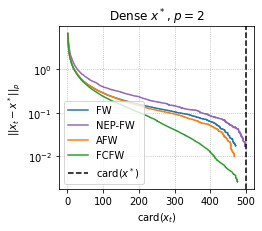

In [ ]:
plotter(res, n, p, s, labels, colors, title='Dense $x^*$, $p=2$')

In [ ]:
for alg in res.keys():
    print(alg, res[alg][2][np.argmax(np.array(res[alg][3]) < 0.02)])

fw 467
nepfw 497
afw 456
fcfw 369


### Sparse $x^*$, $p=2$

In [ ]:
n, p = 500, 2
s = int(n/20)

args = experiment(n, p, s)

In [ ]:
res = {}

print('FW')
res['fw'] = fw(*args, tol=-np.inf, max_iter=15000)
print('NEP-FW')
res['nepfw'] = nepfw(*args)
print('AFW')
res['afw'] = afw(*args)
print('FCFW')
res['fcfw'] = fcfw(*args)

FW
NEP-FW
AFW
FCFW


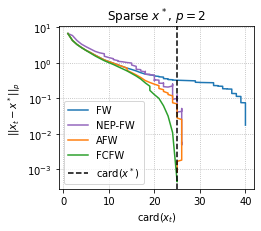

In [ ]:
plotter(res, n, p, s, labels, colors, title='Sparse $x^*$, $p=2$')

In [ ]:
for alg in res.keys():
    print(alg, res[alg][2][np.argmax(np.array(res[alg][3]) < 0.02)])

fw 40
nepfw 26
afw 26
fcfw 24


### Dense $x^*$, $p=3$

In [ ]:
n, p = 500, 3
s = n+1

args = experiment(n, p)

In [ ]:
res = {}

print('FW')
res['fw'] = fw(*args)
print('NEP-FW')
res['nepfw'] = nepfw(*args)
print('AFW')
res['afw'] = afw(*args)
print('FCFW')
res['fcfw'] = fcfw(*args)

FW
NEP-FW
AFW
FCFW


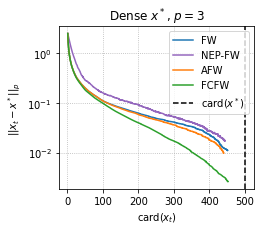

In [ ]:
plotter(res, n, p, s, labels, colors, title='Dense $x^*$, $p=3$')

In [ ]:
for alg in res.keys():
    print(alg, res[alg][2][np.argmax(np.array(res[alg][3]) < 0.02)])

fw 413
nepfw 433
afw 391
fcfw 279


### Sparse $x^*$, $p=3$


In [ ]:
n, p = 500, 3
s = int(n/20)

args = experiment(n, p, s)

In [ ]:
res = {}

print('FW')
res['fw'] = fw(*args)
print('NEP-FW')
res['nepfw'] = nepfw(*args)
print('AFW')
res['afw'] = afw(*args)
print('FCFW')
res['fcfw'] = fcfw(*args)

FW
NEP-FW
AFW
FCFW


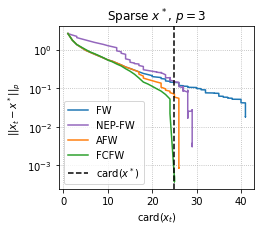

In [ ]:
plotter(res, n, p, s, labels, colors, title='Sparse $x^*$, $p=3$')

In [ ]:
for alg in res.keys():
    print(alg, res[alg][2][np.argmax(np.array(res[alg][3]) < 0.02)])

fw 41
nepfw 28
afw 26
fcfw 25


### Dense $x^*$, $p=7$

In [ ]:
n, p = 500, 7
s = n+1

args = experiment(n, p)

In [ ]:
res = {}

print('FW')
res['fw'] = fw(*args)
print('NEP-FW')
res['nepfw'] = nepfw(*args, max_iter=15000)
print('AFW')
res['afw'] = afw(*args)
print('FCFW')
res['fcfw'] = fcfw(*args)

FW
NEP-FW
AFW
FCFW


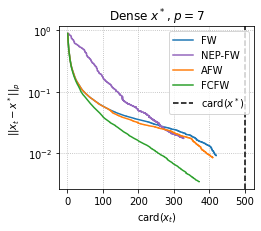

In [ ]:
plotter(res, n, p, s, labels, colors, title='Dense $x^*$, $p=7$')

In [ ]:
for alg in res.keys():
    print(alg, res[alg][2][np.argmax(np.array(res[alg][3]) < 0.02)])

fw 334
nepfw 302
afw 313
fcfw 171


### Sparse $x^*$, $p=7$

In [ ]:
n, p = 500, 7
s = int(n/20)

args = experiment(n, p, s)

In [ ]:
res = {}

print('FW')
res['fw'] = fw(*args)
print('NEP-FW')
res['nepfw'] = nepfw(*args, max_iter=5000)
print('AFW')
res['afw'] = afw(*args)
print('FCFW')
res['fcfw'] = fcfw(*args)

FW
NEP-FW
AFW
FCFW


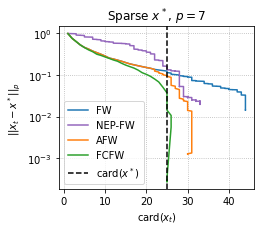

In [ ]:
plotter(res, n, p, s, labels, colors, title='Sparse $x^*$, $p=7$')

In [ ]:
for alg in res.keys():
    print(alg, res[alg][2][np.argmax(np.array(res[alg][3]) < 0.02)])

fw 44
nepfw 33
afw 30
fcfw 25


## Figure 2

### $p=4$

In [ ]:
n, p = 2**6, 4
s = n

args = experiment(n, p, hdmrd=True)

In [ ]:
res = {}

print('FW')
res['fw'] = fw(*args)
print('AFW')
res['afw'] = afw(*args)
print('FCFW')
res['fcfw'] = fcfw(*args, sub_sigd=False)

FW
AFW
FCFW


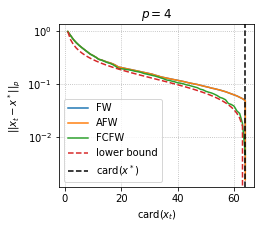

In [ ]:
plotter(res, n, p, s, labels, colors, title='$p=4$', lower=True)

### $p=13$

In [ ]:
n, p = 2**6, 13
s = n

args = experiment(n, p, hdmrd=True)

In [ ]:
res = {}

print('FW')
res['fw'] = fw(*args)
print('AFW')
res['afw'] = afw(*args)
print('FCFW')
res['fcfw'] = fcfw(*args, sub_sigd=False)

FW
NEP-FW
AFW
FCFW


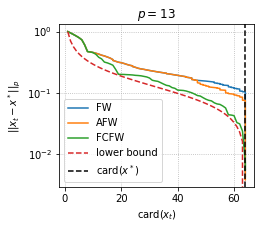

In [ ]:
plotter(res, n, p, s, labels, colors, title='$p=13$', lower=True)